In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from keras.models import load_model
from os.path import join
from bridgescaler import load_scaler
from sealsml.data import Preprocessor
%matplotlib inline

2024-07-19 14:56:03.176437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 14:56:03.875773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
ls /glade/derecho/scratch/dgagne/SEALS_output/2024-07-19_1337/

coord_scaler.json
loc_rate_block_transformer_2024-07-19_1337.keras
loc_rate_block_transformer_model_hist_2024-07-19_1337.csv
loc_rate_block_transformer_output_2024-07-19_1337_train.nc
loc_rate_block_transformer_output_2024-07-19_1337_val.nc
sensor_scaler.json
train_files.csv
train.yml
validation_files.csv


In [5]:
hist = pd.read_csv("/glade/derecho/scratch/dgagne/SEALS_output/2024-07-19_1337/loc_rate_block_transformer_model_hist_2024-07-19_1337.csv")

<Axes: >

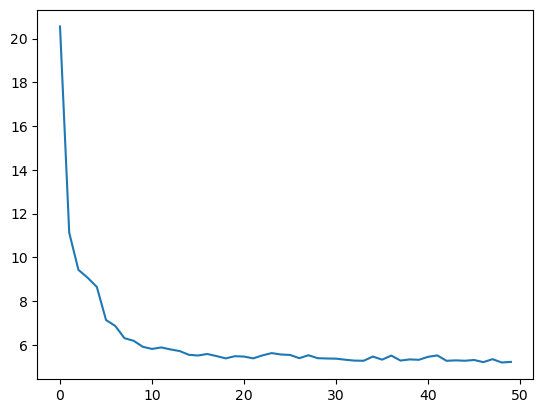

In [12]:
hist["val_mean_searched_locations"].plot()

In [13]:
model_path = "/glade/derecho/scratch/dgagne/SEALS_output/2024-07-19_1337/"

In [15]:
mod = load_model(join(model_path, "loc_rate_block_transformer_2024-07-19_1337.keras"))

2024-07-19 15:00:14.703394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [26]:
mod.summary()

Model: "localized_leak_rate_block_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_block_sensor_encoder       │ ?                      │        11,264 │
│ (TimeBlockSensorEncoder)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ ?                      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_transformer_00          │ ?                      │       391,668 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_transformer_01          │ ?                      │       391,668 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_transformer_02          │ ?                      │       391,668 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_transformer_03          │ ?                      │       391,668 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_transformer_00          │ ?                      │       651,240 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_transformer_01          │ ?                      │       651,240 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_transformer_02          │ ?                      │       651,240 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_hidden (Dense)           │ ?                      │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rate_hidden (Dense)             │ ?                      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rate (Dense)                    │ ?                      │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ location (MaskedSoftmax)        │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,796,960 (41.19 MB)

 Trainable params: 3,598,986 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,197,974 (27.46 MB)

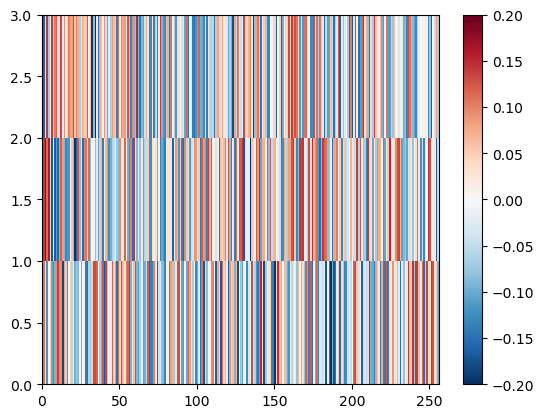

In [30]:
plt.pcolormesh(mod.layers[1].get_weights()[0], cmap="RdBu_r", vmin=-.2, vmax=.2)
plt.colorbar()

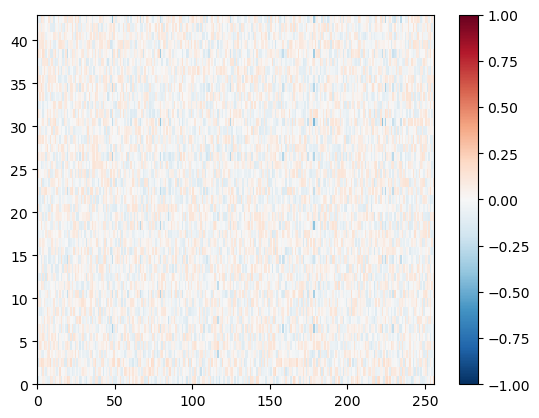

In [41]:
plt.pcolormesh(mod.time_block_sensor_encoder.dense_embedding.get_weights()[0], cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

In [36]:
dir(mod.time_block_sensor_encoder)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_allow_non_tensor_positional_args',
 '_api_export_path',
 '_api_export_symbol_id',
 '_assert_input_compatibility',
 '_auto_config',
 '_build_by_run_for_kwargs',
 '_build_by_run_for_single_pos_arg',
 '_build_shapes_dict',
 '_call_has_mask_arg',
 '_call_has_training_arg',
 '_call_signature',
 '_called',
 '_check_quantize_args',
 '_check_super_called',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_convert_input_args',
 '_copy_trackable_to_cpu',
 '_default_save_signature',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deseria

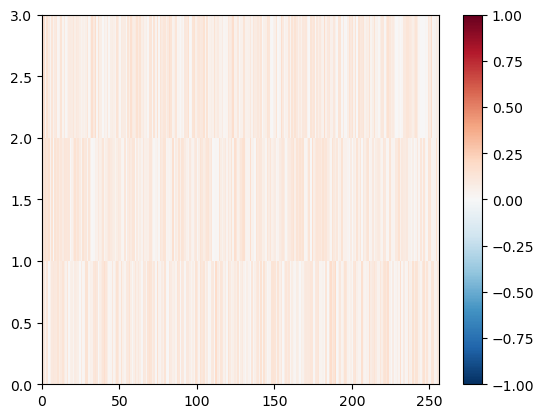

In [14]:
plt.pcolormesh(np.abs(mod.decoder_hidden.get_weights()[0]), cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

In [19]:
mod.time_block_sensor_encoder.dense_embedding

<Dense name=tb_embedding, built=True>

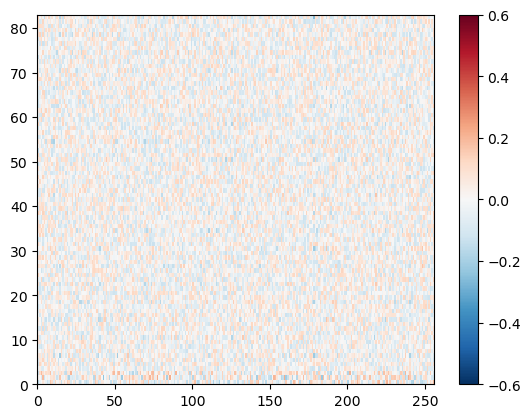

In [20]:
plt.pcolormesh(mod.time_block_sensor_encoder.dense_embedding.get_weights()[0], cmap="RdBu_r", vmin=-0.6, vmax=0.6)
plt.colorbar()

In [69]:
mod.encoder_hidden.get_weights()[0].shape

(560, 128)

In [21]:
mod.n_conv_layers

3

In [4]:
val_ds = xr.open_dataset(join(model_path, "block_transformer_leak_loc_output_2024-06-26_1541_val.nc"))

In [72]:
val_ds

<xarray.Dataset> Size: 101MB
Dimensions:        (sample: 221184, pot_leak_locs: 38)
Dimensions without coordinates: sample, pot_leak_locs
Data variables:
    targets        (sample, pot_leak_locs) int64 67MB ...
    leak_loc_pred  (sample, pot_leak_locs) float32 34MB ...

In [42]:
val_files = pd.read_csv(join(model_path, "validation_files.csv"))

In [43]:
val_files

,Unnamed: 0,validation_files
0,0,/glade/derecho/scratch/dgagne/SEALS_training_d...
1,1,/glade/derecho/scratch/dgagne/SEALS_training_d...
2,2,/glade/derecho/scratch/dgagne/SEALS_training_d...
3,3,/glade/derecho/scratch/dgagne/SEALS_training_d...
4,4,/glade/derecho/scratch/dgagne/SEALS_training_d...
...,...,...
67,67,/glade/derecho/scratch/dgagne/SEALS_training_d...
68,68,/glade/derecho/scratch/dgagne/SEALS_training_d...
69,69,/glade/derecho/scratch/dgagne/SEALS_training_d...
70,70,/glade/derecho/scratch/dgagne/SEALS_training_d...


In [44]:
val_file_ds = xr.open_dataset(val_files["validation_files"][0])

In [7]:
val_file_ds["decoder_input"][1, :, 0, :4, 0]

<xarray.DataArray 'decoder_input' (pot_leak: 38, variable: 4)> Size: 608B
[152 values with dtype=float32]
Coordinates:
  * variable  (variable) <U12 192B 'ref_distance' 'ref_azi_sin' ... 'ref_elv'
Dimensions without coordinates: pot_leak

In [45]:
p = Preprocessor()
encoder_data, decoder_data, leak_location, leak_rate = p.load_data(val_files["validation_files"][0:4])
p.load_scalers(join(model_path, "sensor_scaler.json"), join(model_path, "coord_scaler.json"))
scaled_encoder_data, scaled_decoder_data, encoder_mask, decoder_mask = p.preprocess(encoder_data, decoder_data, fit_scaler=False)


In [47]:
preds = mod.predict((scaled_encoder_data, scaled_decoder_data))

I0000 00:00:1721423275.714242   87997 service.cc:145] XLA service 0x148c7c0076e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721423275.714325   87997 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-07-19 15:07:55.992490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-19 15:07:56.640702: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1721423277.380402   90425 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 60 bytes spill stores, 44 bytes spill loads

I0000 00:00:1721423278.073734   90423 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 60 bytes spill stores, 44 bytes spill loads

I0000 00:00:1721

34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1721423286.235663   87997 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1721423292.298314   90660 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 60 bytes spill stores, 44 bytes spill loads

I0000 00:00:1721423292.957471   90661 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_247', 68 bytes spill stores, 48 bytes spill loads

I0000 00:00:1721423294.380982   90662 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 60 bytes spill stores, 44 bytes spill loads



41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 333ms/step


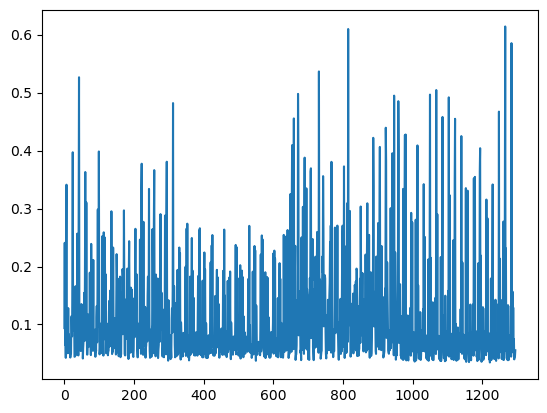

In [54]:
plt.plot(preds[0].max(axis=1))

In [55]:
preds_shuffled_set = []
for v in range(4):
    print(v)
    scaled_decoder_shuffled = np.copy(scaled_decoder_data)
    rng = np.random.default_rng()
    rng.shuffle(scaled_decoder_shuffled[:, :, v], axis=0)
    preds_shuffled = mod.predict((scaled_encoder_data, scaled_decoder_shuffled), batch_size=2048)
    preds_shuffled_set.append(preds_shuffled)

0


I0000 00:00:1721423377.537682   91094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 68 bytes spill stores, 48 bytes spill loads

I0000 00:00:1721423378.651483   91091 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 60 bytes spill stores, 44 bytes spill loads

I0000 00:00:1721423378.945276   91094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_248', 80 bytes spill stores, 80 bytes spill loads

I0000 00:00:1721423379.250719   91094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_248', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1721423379.280043   91098 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_248', 80 bytes spill stores, 80 bytes spill loads

I0000 00:00:1721423379.928126   91096 as

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [56]:
decoder_pred_diffs = np.zeros(4)
for v in range(4):
    decoder_pred_diffs[v] = np.sqrt(np.mean((preds[0] - preds_shuffled_set[v][0]) ** 2))
    print(decoder_data["variable"][v].values, decoder_pred_diffs[v])
    

ref_distance 0.0007456478197127581
ref_azi_sin 0.03579108044505119
ref_azi_cos 0.05067719146609306
ref_elv 0.0


(array([173., 220., 173., 164., 182., 123., 136.,  71.,  36.,  18.]),
 array([ 2.78262162,  4.40805864,  6.03349543,  7.65893269,  9.28436947,
        10.90980625, 12.53524303, 14.16067982, 15.78611755, 17.41155434,
        19.03699112]),
 <BarContainer object of 10 artists>)

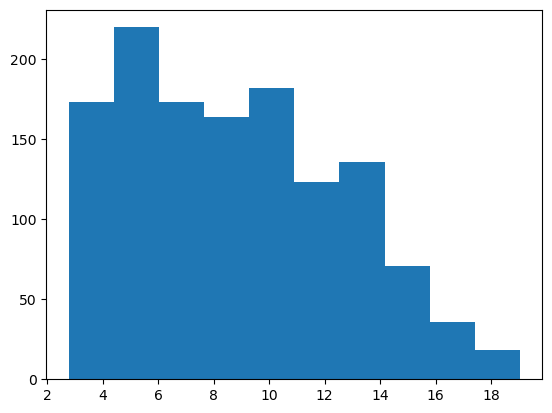

In [60]:
plt.hist(preds[1])

In [57]:
preds_shuffled_enc = []
for v in range(8):
    print(v)
    scaled_encoder_shuffled = np.copy(scaled_encoder_data)
    rng = np.random.default_rng()
    rng.shuffle(scaled_encoder_shuffled[:, :, :, v], axis=0)
    preds_shuffled = mod.predict((scaled_encoder_shuffled, scaled_decoder_data), batch_size=2048)
    preds_shuffled_enc.append(preds_shuffled)

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [59]:
encoder_pred_diffs = np.zeros(8)
for v in range(8):
    encoder_pred_diffs[v] = np.sqrt(np.mean((preds[1] - preds_shuffled_enc[v][1]) ** 2))
    print(encoder_data["variable"][v].values, encoder_pred_diffs[v])

ref_distance 0.0
ref_azi_sin 1.7645775079727173
ref_azi_cos 3.0426185131073
ref_elv 0.0
u 0.020070305094122887
v 0.10873352736234665
w 0.15851745009422302
q_CH4 0.04714639112353325


(array([ 224100.,  245100.,  226800.,  225600.,  223800.,  230700.,
         241500.,  226200.,  237000.,  234600.,  225000.,  236400.,
         238800.,  244200.,  231900.,  234900.,  243300.,  179700.,
              0., 1034400.]),
 array([5.00500493e-04, 4.55205217e-02, 9.05405432e-02, 1.35560557e-01,
        1.80580586e-01, 2.25600600e-01, 2.70620614e-01, 3.15640628e-01,
        3.60660672e-01, 4.05680686e-01, 4.50700700e-01, 4.95720714e-01,
        5.40740728e-01, 5.85760772e-01, 6.30780756e-01, 6.75800800e-01,
        7.20820844e-01, 7.65840828e-01, 8.10860872e-01, 8.55880857e-01,
        9.00900900e-01]),
 <BarContainer object of 20 artists>)

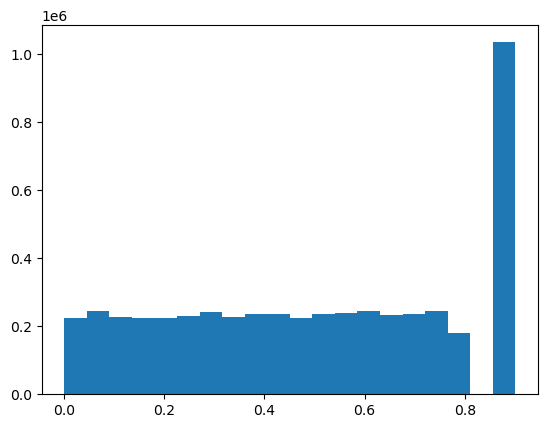

In [195]:
plt.hist(scaled_encoder_data[:, :, :, 2].ravel(), bins=20)

In [186]:
scaled_encoder_data.shape

(3456, 5, 300, 8)

(array([215., 301., 300., 296., 334., 382., 398., 401., 550., 279.]),
 array([-0.39802709, -0.32535496, -0.25268283, -0.18001069, -0.10733856,
        -0.03466643,  0.0380057 ,  0.11067783,  0.18334997,  0.2560221 ,
         0.32869422]),
 <BarContainer object of 10 artists>)

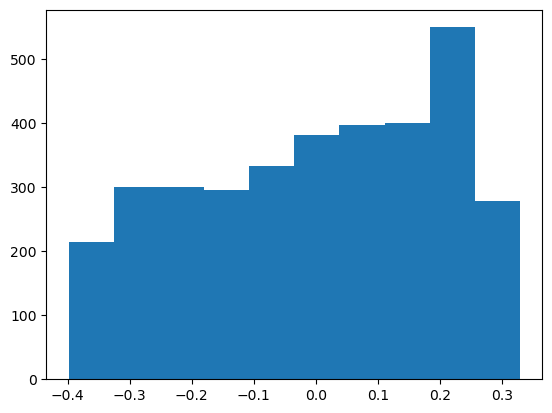

In [168]:
plt.hist(scaled_decoder_data[:, :, 0][leak_location == 1] - scaled_decoder_data[:, :, 0].mean(axis=1))


In [176]:
pdp_inputs = np.arange(0, 1.05, 0.05)
pdp_vals = np.zeros(pdp_inputs.shape)
for p, pdpi in enumerate(pdp_inputs):
    print(p)
    scaled_decoder_data_pdp = np.copy(scaled_decoder_data)
    scaled_decoder_data_pdp[:, :, 3] = pdpi
    pdp_preds = mod.predict((scaled_encoder_data, scaled_decoder_data_pdp), batch_size=1024)
    pdp_vals[p] = pdp_preds.mean()

0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
18
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


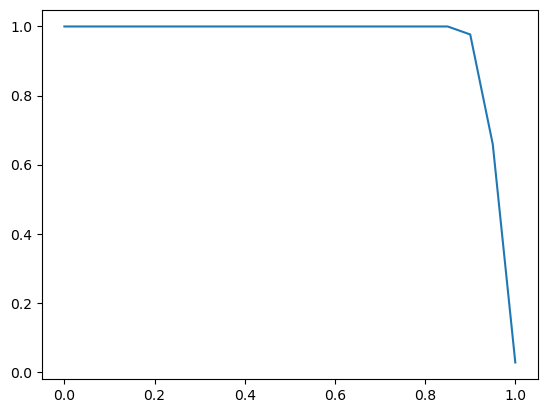

In [177]:
plt.plot(pdp_inputs, pdp_vals)

In [62]:
ds = xr.open_dataset(join(model_path, "loc_rate_block_transformer_output_2024-07-19_1337_val.nc"))

In [66]:
ds

<xarray.Dataset> Size: 11MB
Dimensions:           (sample: 23328, pot_leak_locs: 38)
Dimensions without coordinates: sample, pot_leak_locs
Data variables:
    target_pot_loc    (sample, pot_leak_locs) int64 7MB ...
    leak_loc_pred     (sample, pot_leak_locs) float32 4MB ...
    target_leak_rate  (sample) float32 93kB ...
    leak_rate_pred    (sample) float32 93kB 7.248 20.8 7.014 ... 0.8202 11.37

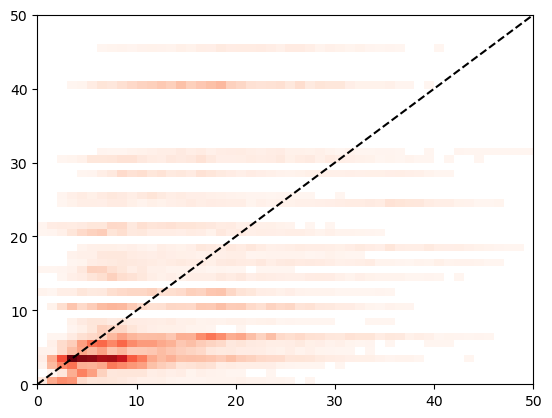

In [77]:
plt.hist2d(ds["leak_rate_pred"].values, ds["target_leak_rate"], np.arange(0, 51, 1), cmin=1, cmap="Reds")
plt.plot(np.arange(51), np.arange(51), 'k--')

In [74]:
from sklearn.metrics import r2_score

In [75]:
r2_score(ds["target_leak_rate"].values, ds["leak_rate_pred"].values)

-0.1173316200303749